### Keywords extraction and visualization (W+J)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import spacy
import operator
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize
from termcolor import colored
import re
import numpy as np
import random
import community
from yellowbrick.style.palettes import SEQUENCES, PALETTES, color_palette
import string
from collections import defaultdict
from collections import OrderedDict
from collections import Counter
import json
import time

### stopwords

In [2]:
data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

### clean function

In [3]:
def clean(text,noun_adj=None): 
    text=re.sub("[\(\[].*?[\)\]]", "", text)
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence) for sentence in sentences] ## lower() implica que se descartan los PROPN
    if noun_adj==None:
        sentences=[[(token.lemma_,token.text) for token in sentence if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ'] for sentence in sentences]
    elif noun_adj==True:
        sentences=[[(token.lemma_,token.text) for token in sentence if token.tag_=='NN' or token.tag_=='NNS'] for sentence in sentences]
    elif noun_adj==False:
        sentences=[[(token.lemma_,token.text) for token in sentence if token.lemma_ != '-PRON-' and token.is_punct==False and token.like_num==False] for sentence in sentences]
    TEXT=[item for sublist in sentences for item in sublist]
    TEXT=[(word_l,word_nl.lower()) for (word_l,word_nl) in TEXT if not word_l in stop_words or not word_nl in stop_words]
    TEXT=[(re.sub(r'[^a-zA-Z0-9]', '', word_l),word_nl) for (word_l,word_nl) in TEXT]
    TEXT=[(word_l,word_nl) for (word_l,word_nl) in TEXT if word_l.isdigit()==False and word_l!='' and word_nl.isdigit()==False and word_nl!='']
    dict_text=list(set(TEXT))
    dict_text={word_nl:word_l for (word_l,word_nl) in dict_text}
    return list(zip(*TEXT))[0],dict_text ## texto filtrado, diccionario de word original: word modificada

### ejemplo

In [4]:
text='Regulatory variation influencing gene expression is a key contributor to phenotypic diversity, both within and between species. Unfortunately, RNA degrades too rapidly to be recovered from fossil remains, limiting functional genomic insights about our extinct hominin relatives. Many Neanderthal sequences survive in modern humans due to ancient hybridization, providing an opportunity to assess their contributions to transcriptional variation and to test hypotheses about regulatory evolution. We developed a flexible Bayesian statistical approach to quantify allele-specific expression (ASE) in complex RNA-seq datasets. We identified widespread expression differences between Neanderthal and modern human alleles, indicating pervasive cis-regulatory impacts of introgression. Brain regions and testes exhibited significant downregulation of Neanderthal alleles relative to other tissues, consistent with natural selection influencing the tissue-specific regulatory landscape. Our study demonstrates that Neanderthal-inherited sequences are not silent remnants of ancient interbreeding but have measurable impacts on gene expression that contribute to variation in modern human phenotypes.'
text_clean,dict_words=clean(text)

In [5]:
text_clean

('regulatory',
 'variation',
 'gene',
 'expression',
 'key',
 'contributor',
 'phenotypic',
 'diversity',
 'specie',
 'degrade',
 'fossil',
 'remain',
 'functional',
 'genomic',
 'insight',
 'extinct',
 'hominin',
 'relative',
 'many',
 'neanderthal',
 'sequence',
 'modern',
 'human',
 'due',
 'ancient',
 'hybridization',
 'opportunity',
 'contribution',
 'transcriptional',
 'variation',
 'hypothesis',
 'regulatory',
 'evolution',
 'flexible',
 'bayesian',
 'statistical',
 'approach',
 'allele',
 'specific',
 'expression',
 'complex',
 'dataset',
 'widespread',
 'expression',
 'difference',
 'neanderthal',
 'modern',
 'human',
 'allele',
 'pervasive',
 'cis',
 'regulatory',
 'impact',
 'introgression',
 'brain',
 'region',
 'testis',
 'significant',
 'downregulation',
 'neanderthal',
 'allele',
 'relative',
 'tissue',
 'consistent',
 'natural',
 'selection',
 'tissue',
 'specific',
 'regulatory',
 'landscape',
 'study',
 'sequence',
 'silent',
 'remnant',
 'ancient',
 'measurable',
 'i

In [6]:
dict_words

{'allele': 'allele',
 'alleles': 'allele',
 'ancient': 'ancient',
 'approach': 'approach',
 'bayesian': 'bayesian',
 'brain': 'brain',
 'cis': 'cis',
 'complex': 'complex',
 'consistent': 'consistent',
 'contributions': 'contribution',
 'contributor': 'contributor',
 'datasets': 'dataset',
 'degrades': 'degrade',
 'differences': 'difference',
 'diversity': 'diversity',
 'downregulation': 'downregulation',
 'due': 'due',
 'evolution': 'evolution',
 'expression': 'expression',
 'extinct': 'extinct',
 'flexible': 'flexible',
 'fossil': 'fossil',
 'functional': 'functional',
 'gene': 'gene',
 'genomic': 'genomic',
 'hominin': 'hominin',
 'human': 'human',
 'humans': 'human',
 'hybridization': 'hybridization',
 'hypotheses': 'hypothesis',
 'impacts': 'impact',
 'insights': 'insight',
 'introgression': 'introgression',
 'key': 'key',
 'landscape': 'landscape',
 'many': 'many',
 'measurable': 'measurable',
 'modern': 'modern',
 'natural': 'natural',
 'neanderthal': 'neanderthal',
 'opportunit

## GoW extraction

In [7]:
# K es el largo de la ventana
# text_clean es una lista de palabras de un texto ya procesado por clean
# digraph indica el tipo de grafo- True = dirigido, False = no dirigido
def GoW(text_clean,digraph=None,K=None):
    if K==None:
        K=6
    if digraph==None:
        digraph=False
    unique_words=list(set(text_clean))
    if digraph==True: ## grafo dirigido o no dirigido
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    for word in unique_words:
        G.add_node(word)
    for word in unique_words: ## recorremos el texto y encontramos los índices de todas las aparicions de word (index_word)
        index_word=[index for index, value in enumerate(text_clean) if value == word]
        ## ahora buscamos las palabras vecinas en una ventana de largo K (hacia adelante!)
        for index in index_word:
            for k in range(1,K+1):
                if index+k in range(len(text_clean)):
                    if G.has_edge(text_clean[index],text_clean[index+k])==False:
                        G.add_edge(text_clean[index],text_clean[index+k],weight=1)
                    else:
                        x=G[text_clean[index]][text_clean[index+k]]['weight']
                        G[text_clean[index]][text_clean[index+k]]['weight']=x+1
    
    return G

In [8]:
start = time.time()
GoW(text_clean)
end = time.time()
print(end - start)

0.009096384048461914


## GoW visualization

In [9]:
def GoW_visualization(text_clean,dict_words):
    G=GoW(text_clean)
    BC_nodes=nx.betweenness_centrality(G,weight='weight')
    node_sizes=list(BC_nodes.values())
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    labels={i:D[i] for i in G.nodes if BC_nodes[i]>0.004}
    node_color=[BC_nodes[i] if BC_nodes[i]>0.004 else 0 for i in G.nodes()]
        
    nx.draw_networkx_nodes(G, pos, node_size = [10000*x for x in node_sizes],node_color=list(BC_nodes.values()),cmap=plt.cm.Oranges) ## node_size según BC
    nx.draw_networkx_edges(G, pos, alpha=0.5,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=7,font_color='k',font_family='sans-serif')
    plt.axis('off')
    plt.savefig('GoW_visualization.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=300)
    plt.show()

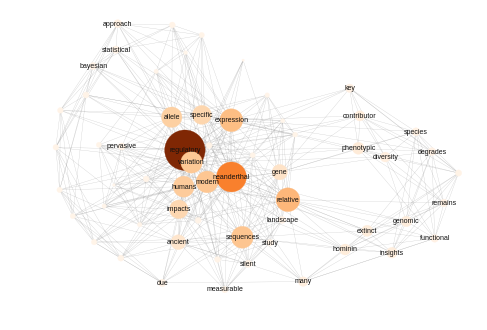

0.889275312423706


In [10]:
start = time.time()
GoW_visualization(text_clean,dict_words)
end = time.time()
print(end - start)

In [11]:
def GoW_visualization_louvain(text_clean,dict_words):
    G=GoW(text_clean)
    BC_nodes=nx.betweenness_centrality(G,weight='weight')
    node_sizes=list(BC_nodes.values())
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    color_names=PALETTES['set1']#SEQUENCES['OrRd'][7]
    d = community.best_partition(G)
    if max(list(d.values())) not in range(len(color_names)): ## > 9 comunidades
        colors={x:'r' for x in list(d.keys())}
    else:
        colors={x:color_names[d[x]] for x in list(d.keys())}
    labels={i:D[i] for i in G.nodes if BC_nodes[i]>0.004}
    nx.draw_networkx_nodes(G, pos, node_size = [10000*x for x in node_sizes],node_color=list(colors.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=7,font_color='k')
    plt.axis('off')
    plt.savefig('GoW_visualization_louvain.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=300)
    plt.show()

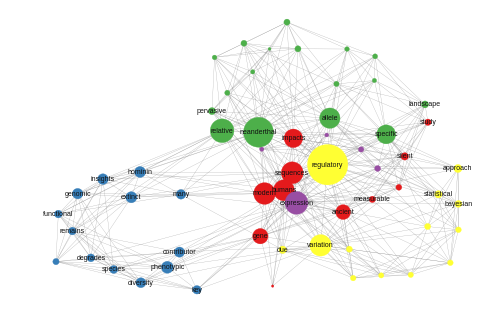

0.5826137065887451


In [12]:
start = time.time()
GoW_visualization_louvain(text_clean,dict_words)
end = time.time()
print(end - start)

In [13]:
def communities(text_clean,dict_words,lemmatization=None):
    G = GoW(text_clean)
    C = community.best_partition(G)
    BC = nx.betweenness_centrality(G,weight='weight')
    C_value = defaultdict(list)
    for key, value in sorted(C.items()):
        C_value[value].append(key)
    C_value=dict(C_value)
    D = dict(map(reversed, dict_words.items()))
    for key in C_value.keys():
        bow=[]
        for word in C_value[key]:
            bow+=[word]
        bow_dict={word:BC[word] for word in bow} ## sorted by BC
        bow_dict=sorted(bow_dict.items(), key=lambda kv: kv[1],reverse=True)
        C_value[key]=list(zip(*bow_dict))[0]
        if lemmatization == None:
            C_value[key]=[D[word] for word in C_value[key]]
        elif lemmatization == False:
            C_value[key]=[word for word in C_value[key]]
    return C_value

In [14]:
start = time.time()
print(communities(text_clean,dict_words))
end = time.time()
print(end - start)

{1: ['neanderthal', 'relative', 'allele', 'specific', 'pervasive', 'landscape', 'downregulation', 'significant', 'testes', 'tissues', 'cis', 'natural', 'regions', 'consistent', 'introgression', 'selection', 'brain'], 2: ['sequences', 'modern', 'humans', 'impacts', 'gene', 'ancient', 'silent', 'study', 'measurable', 'remnants', 'phenotypes'], 4: ['regulatory', 'variation', 'approach', 'due', 'statistical', 'bayesian', 'flexible', 'hybridization', 'evolution', 'hypotheses', 'opportunity', 'transcriptional', 'contributions'], 3: ['expression', 'complex', 'datasets', 'differences', 'widespread'], 0: ['phenotypic', 'extinct', 'hominin', 'insights', 'genomic', 'contributor', 'diversity', 'many', 'key', 'species', 'degrades', 'functional', 'remains', 'fossil']}
0.14812397956848145


## Main core words

In [15]:
def main_core_words(text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    main_core=nx.k_core(G)
    D=dict(map(reversed, dict_words.items()))
    mc=list(main_core.nodes())
    if lemmatization==None:
        return [D[w] for w in mc]
    elif lemmatization==False:
        return mc

In [16]:
start = time.time()
main_core_words(text_clean,dict_words)
end = time.time()
print(end - start)

0.010881900787353516


## Main core visualization

In [21]:
def main_core_visualization(text_clean,dict_words):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    G=nx.k_core(G)
    BC_nodes=nx.betweenness_centrality(G,weight='weight')
    node_sizes=list(BC_nodes.values())
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    labels={i:D[i] for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_size = [10000*x for x in node_sizes],node_color='orange')
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=7,font_color='k')
    plt.axis('off')
    plt.savefig('main_core_visualization.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=300)
    plt.show()

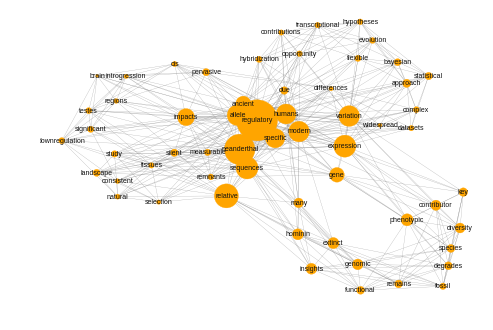

0.7367515563964844


In [22]:
start = time.time()
main_core_visualization(text_clean,dict_words)
end = time.time()
print(end - start)

## Main core extraction según segun Core Rank
### http://www.lix.polytechnique.fr/~anti5662/eacl_17_real_time_meladianos_tixier_nikolentzos_vazirgiannis.pdf

In [20]:
def main_core_words_core_rank(text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    core_number=nx.core_number(G) ## core number de los nodos de G
    core_rank={word:sum([core_number[w] for w in list(dict(G[word]).keys())]) for word in list(core_number.keys())}
    main_core_nodes=list(nx.k_core(G).nodes())
    ## ahora vemos el core rank de los nodos del main core
    main_core_rank=[]
    for node in main_core_nodes:
        main_core_rank+=[(node,core_rank[node])]
    ## ordenamos segun core rank decreciente
    main_core_rank=sorted(main_core_rank, key=lambda tup: tup[1],reverse=True)
    mc=list(zip(*main_core_rank))[0]
    ## diccionario inverso!
    D=dict(map(reversed, dict_words.items()))
    
    if lemmatization==None:
        return [D[w] for w in mc]
    elif lemmatization==False:
        return mc

In [21]:
start = time.time()
main_core_words_core_rank(text_clean,dict_words)
end = time.time()
print(end - start)

0.017765045166015625


## n-gramas de palabras del main core

In [22]:
def main_core_ngrams(text,text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) 
    d=nx.core_number(G) ## diccionario de palabras asociadas a un core
    max_core=max(d.values())
    text=[w.lower() for w in word_tokenize(text)]
    c=[]
    for word in text:
        if word in dict_words.keys():
            if d[dict_words[word]]==max_core:
                if lemmatization==None:
                    c+=[word]
                elif lemmatization==False:
                    c+=[dict_words[word]]
            else:
                c+=['X']
        else:
            c+=['X']
    s=' '.join(c)
    ngrams=[token.rstrip().lstrip() for token in s.split('X') if token!=' ' and token!='']
    L=[[len(word_tokenize(token)),token] for token in ngrams]
    o = OrderedDict()
    for x in L:
        o.setdefault(x[0], []).append(x[1])
    for key in o.keys():
        if len(o[key])>1:
            o[key]=list(list(zip(*Counter(o[key]).most_common()))[0]) ## ordenamos por frecuencia
        
    return dict(o)

In [23]:
start = time.time()
main_core_ngrams(text,text_clean,dict_words)
end = time.time()
print(end - start)

0.028063058853149414


## Division tripartita de un texto

In [24]:
def tripartite_words(text_clean,dict_words,lemmatization=None):
    
    G = GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    main_core = nx.k_core(G)
    k_crust = nx.k_crust(G)
    Gcc = sorted(nx.connected_component_subgraphs(k_crust), key=len, reverse=True)
    G0 = Gcc[0]
    Gi = nx.union_all(Gcc[1:])
    
    try:
        mc = list(main_core.nodes())
    except AttributeError:
        mc = []
        
    try:
        G0 = list(G0.nodes())
    except AttributeError:
        G0 = []
        
    try:
        Gi = list(Gi.nodes())
    except AttributeError:
        Gi = []
    
    D = dict(map(reversed, dict_words.items()))
    
    if lemmatization == None:
        
        if len(mc)>0:
            mc = [D[w] for w in mc]
        if len(G0)>0:
            G0 = [D[w] for w in G0]
        if len(Gi)>0:
            Gi = [D[w] for w in Gi]
        
        return [mc,G0,Gi]
    
    elif lemmatization == False:
        
        return [mc,G0,Gi]

In [25]:
start = time.time()
mc,crust,isolated=tripartite_words(text_clean,dict_words)
end = time.time()
print(end - start)

0.02230381965637207


In [26]:
mc

['factor',
 'speed',
 'lincrna',
 'majority',
 'many',
 'polished',
 'orfs',
 'transcripts',
 'genomes',
 'stem',
 'embryonic',
 'application',
 'profiling',
 'gene',
 'protein',
 'translational',
 'impact',
 'structure',
 'class',
 'mrna',
 'important',
 'length',
 'synthesis',
 'unannotated',
 'organisms',
 'rival',
 'deep',
 'initiation',
 'locations',
 'general',
 'leaky',
 'results',
 'question',
 'precise',
 'applicable',
 'exceptions',
 'accuracy',
 'fragments',
 'series',
 'translation',
 'approach',
 'annotated',
 'atypical',
 'transcription',
 'regions',
 'key',
 'rice',
 'ribosome',
 'unaddressed',
 'constant',
 'depth',
 'scheme',
 'strategy',
 'wide',
 'challenging',
 'activity',
 'rates',
 'single',
 'internal',
 'polycistronic',
 'range',
 'strong',
 'pauses',
 'sites',
 'reinitiation',
 'codon',
 'abundant',
 'usage',
 'reading',
 'regulatory',
 'shavenbaby',
 'rnas',
 'entry',
 'potential',
 'complex',
 'canonical',
 'coding',
 'sequence',
 'tarsal',
 'sequencing',
 'c

In [27]:
crust

['cost',
 'comprehensive',
 'genomic',
 'biological',
 'central',
 'simple',
 'years',
 'advances',
 'technology',
 'community',
 'challenge',
 'draft',
 'dna',
 'human',
 'extraordinary',
 'publication',
 'low',
 'nature']

In [28]:
isolated

['active',
 'transcriptomes',
 'mammalian',
 'kinetics',
 'drug',
 'machine',
 'simplified',
 'algorithm',
 'protocol',
 'systems',
 'robust',
 'run',
 'positions',
 'technique',
 'snapshot',
 'harringtonine',
 'elongation',
 'mechanisms',
 'production',
 'molecular']

## Visualización de división tripartita

In [29]:
def GoW_tripartite_visualization(text_clean,dict_words):
    
    G = GoW(text_clean)
    tripartite = tripartite_words(text_clean,dict_words,lemmatization=False)
    d = {}
    nodes_GoW = list(G.nodes())
    
    for node in nodes_GoW:
        if node in tripartite[0]:
            d[node]=0
            
        elif node in tripartite[1]:
            d[node]=1
        
        else:
            d[node]=2
    
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    
    color_names=sorted(SEQUENCES['Reds'][3])
    colors={x:color_names[d[x]] for x in list(d.keys())}
    labels={i:D[i] for i in G.nodes}
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 175,node_color=list(colors.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=6,font_color='k')
    plt.axis('off')
    plt.savefig('GoW_visualization_tripartite.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=1000)
    plt.show()

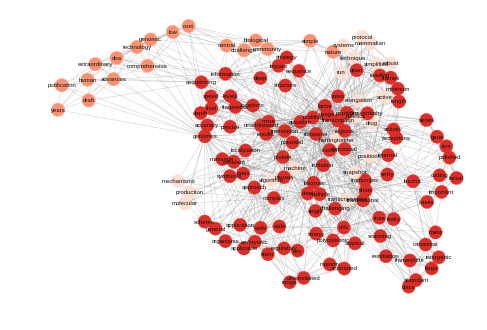

2.6271979808807373


In [30]:
start = time.time()
GoW_tripartite_visualization(text_clean,dict_words)
end = time.time()
print(end - start)